<a href="https://colab.research.google.com/github/h-razu/deepfake-detection/blob/main/deepfake_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hadayet Ullah Razu <br>
st20313374

In [ ]:
!nvidia-smi

Sun Aug  3 07:55:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             40W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch
print(torch.cuda.get_device_name(0))

NVIDIA L4


## Prepare the Environment

#### Download Required Library

In [ ]:
!pip install opencv-python insightface onnxruntime-gpu timm

In [ ]:
!pip install torchinfo

#### Import Required Library

In [ ]:
import random
import shutil
import sys
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import PIL
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from collections import Counter

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#### Check the Version of Library

In [ ]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("==============================")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version : ", PIL.__version__)
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version :  11.3.0
CV2 version :  4.12.0
torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124


#### Check GPU Availability

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


#### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets

#### Download FaceForensics Dataset

In [ ]:
%%writefile faceforensics_download.py

#!/usr/bin/env python
""" Downloads FaceForensics++ and Deep Fake Detection public data release
Example usage:
    see -h or https://github.com/ondyari/FaceForensics
"""
# -*- coding: utf-8 -*-
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join


# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original_youtube_videos': 'misc/downloaded_youtube_videos.zip',
    'original_youtube_videos_info': 'misc/downloaded_youtube_videos_info.zip',
    'original': 'original_sequences/youtube',
    'DeepFakeDetection_original': 'original_sequences/actors',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'DeepFakeDetection': 'manipulated_sequences/DeepFakeDetection',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceShifter': 'manipulated_sequences/FaceShifter',
    'FaceSwap': 'manipulated_sequences/FaceSwap',
    'NeuralTextures': 'manipulated_sequences/NeuralTextures'
    }
ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
                'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
                'NeuralTextures']
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-d', '--dataset', type=str, default='all',
                        help='Which dataset to download, either pristine or '
                             'manipulated data or the downloaded youtube '
                             'videos.',
                        choices=list(DATASETS.keys()) + ['all']
                        )
    parser.add_argument('-c', '--compression', type=str, default='raw',
                        help='Which compression degree. All videos '
                             'have been generated with h264 with a varying '
                             'codec. Raw (c0) videos are lossless compressed.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type, i.e. videos, masks, for our '
                             'manipulation methods, models, for Deepfakes.',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=None,
                        help='Select a number of videos number to '
                             "download if you don't want to download the full"
                             ' dataset.')
    parser.add_argument('--server', type=str, default='EU',
                        help='Server to download the data from. If you '
                             'encounter a slow download speed, consider '
                             'changing the server.',
                        choices=SERVERS
                        )
    args = parser.parse_args()

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        if report_progress:
            urllib.request.urlretrieve(url, out_file_tmp,
                                       reporthook=reporthook)
        else:
            urllib.request.urlretrieve(url, out_file_tmp)
        os.rename(out_file_tmp, out_file)
    else:
        tqdm.write('WARNING: skipping download of existing file ' + out_file)


def main(args):
    # TOS
    print('By pressing any key to continue you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')
    print('Press any key to continue, or CTRL-C to exit.')
    _ = input('')

    # Extract arguments
    c_datasets = [args.dataset] if args.dataset != 'all' else ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            # Here we download the original youtube videos zip file
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
                suffix = 'info'
                download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists and video lenghts list from server
        if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
            filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
            if 'actors' in dataset_path:
                filelist = filepaths['actors']
            else:
                filelist = filepaths['DeepFakesDetection']
        elif 'original' in dataset_path:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            filelist = []
            for pair in file_pairs:
                filelist += pair
        else:
            # Load filelist from server
            file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                FILELIST_URL).read().decode("utf-8"))
            # Get filelist
            filelist = []
            for pair in file_pairs:
                filelist.append('_'.join(pair))
                if c_type != 'models':
                    filelist.append('_'.join(pair[::-1]))

        # Maybe limit number of videos for download
        if num_videos is not None and num_videos > 0:
            print('Downloading the first {} videos'.format(num_videos))
            filelist = filelist[:num_videos]

        # Server and local paths
            dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
            dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)

        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                if args.dataset != 'all':
                    print('Only videos available for original data. Aborting.')
                    return
                else:
                    print('Only videos available for original data. '
                          'Skipping original.\n')
                    continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)

        # Else: models for deepfakes
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            # Get Deepfakes models
            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES

                # Folder paths
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)   # already done


if __name__ == "__main__":
    args = parse_args()
    main(args)


Writing faceforensics_download.py


In [ ]:
output_path = '/content/drive/MyDrive/dataset/faceforensics'

In [ ]:
import shutil
import os

os.makedirs(output_path, exist_ok=True)
# Remove existing dataset folder (if any)
if os.path.exists(output_path):
    print(f"Deleting existing folder: {output_path}")
    shutil.rmtree(output_path)

# Recreate a clean folder
os.makedirs(output_path, exist_ok=True)

Deleting existing folder: /content/drive/MyDrive/dataset/faceforensics


In [ ]:
# download `original` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d original \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/original_sequences/youtube/raw/videos
100% 1/1 [00:26<00:00, 26.15s/it]


In [ ]:
# download `Face2Face` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d Face2Face \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/Face2Face/raw/videos
100% 1/1 [00:40<00:00, 40.23s/it]


In [ ]:
# download `FaceSwap` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d FaceSwap \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/FaceSwap/raw/videos
100% 1/1 [00:28<00:00, 28.93s/it]


In [ ]:
# download `Deepfakes` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d Deepfakes \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/Deepfakes/raw/videos
100% 1/1 [00:22<00:00, 22.36s/it]


In [ ]:
# download `NeuralTextures` dataset
!python faceforensics_download.py "/content/drive/My Drive/dataset/faceforensics" \
    -d NeuralTextures \
    -c raw \
    -t videos \
    -n 1 \
    --server EU2

By pressing any key to continue you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Press any key to continue, or CTRL-C to exit.

Output path: /content/drive/My Drive/dataset/faceforensics/manipulated_sequences/NeuralTextures/raw/videos
100% 1/1 [01:14<00:00, 74.90s/it]


#### Access Datasets

In [ ]:
%cd '/content/drive/MyDrive/dataset/'

/content/drive/MyDrive/dataset


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (55.2 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


#### Accessing FaceForensics Dataset

In [ ]:
!tree faceforensics --filelimit=10

faceforensics
├── manipulated_sequences
│   ├── Deepfakes
│   │   └── raw
│   │       └── videos  [250 entries exceeds filelimit, not opening dir]
│   ├── Face2Face
│   │   └── raw
│   │       └── videos  [250 entries exceeds filelimit, not opening dir]
│   ├── FaceSwap
│   │   └── raw
│   │       └── videos  [250 entries exceeds filelimit, not opening dir]
│   └── NeuralTextures
│       └── raw
│           └── videos  [250 entries exceeds filelimit, not opening dir]
└── original_sequences
    └── youtube
        └── raw
            └── videos  [250 entries exceeds filelimit, not opening dir]

17 directories, 0 files


#### Organized DFDC Dataset

In [ ]:
import os
import json
import shutil

# Base paths
base_dir = "dfdc"
raw_dir = os.path.join(base_dir, "raw_dfdc")
structured_dir = os.path.join(base_dir, "structured_dfdc")
fake_dir = os.path.join(structured_dir, "fake")
real_dir = os.path.join(structured_dir, "real")
metadata_path = os.path.join(raw_dir, "metadata.json")

# === Early exit if organized folders already exist and are not empty ===
if os.path.exists(fake_dir) and os.path.exists(real_dir):
    if len(os.listdir(fake_dir)) > 0 and len(os.listdir(real_dir)) > 0:
        print("structured_dfdc already exists and is populated — skipping organization.")

else:
  # Create structured folders if not already created
  os.makedirs(fake_dir, exist_ok=True)
  os.makedirs(real_dir, exist_ok=True)

  # Load metadata
  with open(metadata_path, "r") as f:
      metadata = json.load(f)

  # Tracking
  copied_reals = set()
  skipped = {
      "missing_fake": [],
      "missing_real": [],
      "missing_original_key": [],
  }

  # Process each entry
  for video_filename, info in metadata.items():
      label = info.get("label")

      if label == "FAKE":
          original = info.get("original")
          fake_src = os.path.join(raw_dir, video_filename)
          fake_dst = os.path.join(fake_dir, video_filename)

          # Copy FAKE video
          if os.path.exists(fake_src):
              shutil.copy2(fake_src, fake_dst)
          else:
              skipped["missing_fake"].append(video_filename)
              continue

          # Copy REAL (original) video
          if original:
              real_src = os.path.join(raw_dir, original)
              real_dst = os.path.join(real_dir, original)

              if os.path.exists(real_src):
                  if original not in copied_reals:
                      shutil.copy2(real_src, real_dst)
                      copied_reals.add(original)
              else:
                  skipped["missing_real"].append(original)
          else:
              skipped["missing_original_key"].append(video_filename)

  # Summary
  print("\nOrganizing complete.")
  print(f"Fake videos copied: {len(os.listdir(fake_dir))}")
  print(f"Real videos copied: {len(os.listdir(real_dir))}")

structured_dfdc already exists and is populated — skipping organization.


#### Accessing DFDC Dataset

In [ ]:
!tree dfdc --filelimit=10

dfdc
├── raw_dfdc  [1255 entries exceeds filelimit, not opening dir]
└── structured_dfdc
    ├── fake  [1170 entries exceeds filelimit, not opening dir]
    └── real  [83 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Preprocessing

In [ ]:
%cd /content/

/content


### Frame Extraction, Face Detection and Cropping

##### RetinaFace

Performed **`frame extraction`** from each video by sampling every 5th frame to reduce redundancy and ensure manageable processing. Then, I used **`RetinaFace`**, a GPU-accelerated face detector, to locate and crop the most prominent face from each sampled frame. This step isolates the facial region, which is the primary area manipulated in deepfake videos. The cropped faces were resized and saved for training a deep learning model. This preprocessing ensures consistent input quality and focuses the model on the most relevant visual features for accurate deepfake detection.


In [ ]:
%%writefile retina_face_extraction.py

import os
import cv2
import numpy as np
from pathlib import Path
from insightface.app import FaceAnalysis
from tqdm import tqdm

os.environ['INSIGHTFACE_HOME'] = '/content/drive/MyDrive/insightface_models'

# Prepare face analysis once at module level
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
app.prepare(ctx_id=0)

class RetinaFacePreprocessor:
    def __init__(self, base_input_dir, base_output_dir, frame_count=10, target_size=(224, 224),
                 max_videos_per_class=None, dataset_type="faceforensics"):
        self.base_input_dir = base_input_dir
        self.base_output_dir = base_output_dir
        self.frame_count = frame_count
        self.target_size = target_size
        self.max_videos = max_videos_per_class
        self.dataset_type = dataset_type.lower()

        self.face_analyzer = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider'])
        self.face_analyzer.prepare(ctx_id=0)

        if self.dataset_type == "faceforensics":
            self.fake_sources = [
                "manipulated_sequences/Deepfakes/raw/videos",
                "manipulated_sequences/Face2Face/raw/videos",
                "manipulated_sequences/FaceSwap/raw/videos",
                "manipulated_sequences/NeuralTextures/raw/videos"
            ]
            self.real_source = "original_sequences/youtube/raw/videos"
        elif self.dataset_type == "dfdc":
            self.fake_sources = ["fake"]
            self.real_source = "real"
        else:
            raise ValueError(f"Unsupported dataset type: {self.dataset_type}")

    def extract_faces_from_video(self, video_path, save_dir):
        cap = cv2.VideoCapture(str(video_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(total_frames // self.frame_count, 1)
        saved_count = 0

        for i in range(self.frame_count):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
            ret, frame = cap.read()
            if not ret:
                continue

            faces = self.face_analyzer.get(frame)
            if faces:
                face = max(faces, key=lambda f: (f.bbox[2] - f.bbox[0]) * (f.bbox[3] - f.bbox[1]))
                box = face.bbox.astype(int)
                x1, y1, x2, y2 = np.clip(box, 0, None)
                face_crop = frame[y1:y2, x1:x2]
                if face_crop.size == 0:
                    continue

                face_resized = cv2.resize(face_crop, self.target_size)
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f"frame_{saved_count:05d}.jpg")
                cv2.imwrite(save_path, face_resized)
                saved_count += 1

            if saved_count >= self.frame_count:
                break

        cap.release()

    def process_folder(self, input_folder, label):
        if not os.path.exists(input_folder):
            print(f"[!] Skipping {input_folder} — path does not exist.")
            return

        video_files = list(Path(input_folder).glob("*.mp4"))
        if self.max_videos:
            video_files = video_files[:self.max_videos]

        print(f"\nProcessing {label.upper()} from {input_folder} ({len(video_files)} videos)")

        for video_file in tqdm(video_files):
            video_name = video_file.stem
            output_dir = os.path.join(self.base_output_dir, label, video_name)

            if os.path.exists(output_dir) and len(os.listdir(output_dir)) >= self.frame_count:
                continue

            try:
                self.extract_faces_from_video(video_file, output_dir)
            except Exception as e:
                print(f"[!] Failed to process {video_file.name}: {e}")

    def run(self):
        # Process REAL
        real_path = os.path.join(self.base_input_dir, self.real_source)
        self.process_folder(real_path, "real")

        # Process FAKE
        for fake_rel_path in self.fake_sources:
            # For FF++, use subdir name as label (e.g. fake/Deepfakes)
            # For DFDC, just use "fake"
            label = f"fake/{Path(fake_rel_path).name}" if self.dataset_type == "faceforensics" else "fake"
            full_input_path = os.path.join(self.base_input_dir, fake_rel_path)
            self.process_folder(full_input_path, label)

Writing retina_face_extraction.py


### Preprocess FaceForensics++ Dataset

In [ ]:
from retina_face_extraction import RetinaFacePreprocessor
import os
import shutil

# Set input/output paths
ff_input_dir = '/content/drive/MyDrive/dataset/faceforensics'
ff_output_dir = '/content/drive/MyDrive/dataset/processed/faceforensics'
real_dir = os.path.join(ff_output_dir, "real")
fake_dir = os.path.join(ff_output_dir, "fake")

# === Early Exit Check ===
if os.path.exists(real_dir) and os.path.exists(fake_dir):
    if len(os.listdir(real_dir)) > 0 and len(os.listdir(fake_dir)) > 0:
        print("Preprocessing already done — skipping.")
    else:
        print("Output folder exists but is empty — proceeding with preprocessing.")
        # Optionally clean up incomplete run
        shutil.rmtree(ff_output_dir)
        os.makedirs(ff_output_dir)

        ff_processor = RetinaFacePreprocessor(ff_input_dir, ff_output_dir)
        ff_processor.run()
else:
    print("[→] Starting preprocessing.")
    os.makedirs(ff_output_dir, exist_ok=True)
    ff_processor = RetinaFacePreprocessor(ff_input_dir, ff_output_dir)
    ff_processor.run()

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 101303.72KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

##### Display Sample Image from Preprocessed FaceForensics++ Dataset

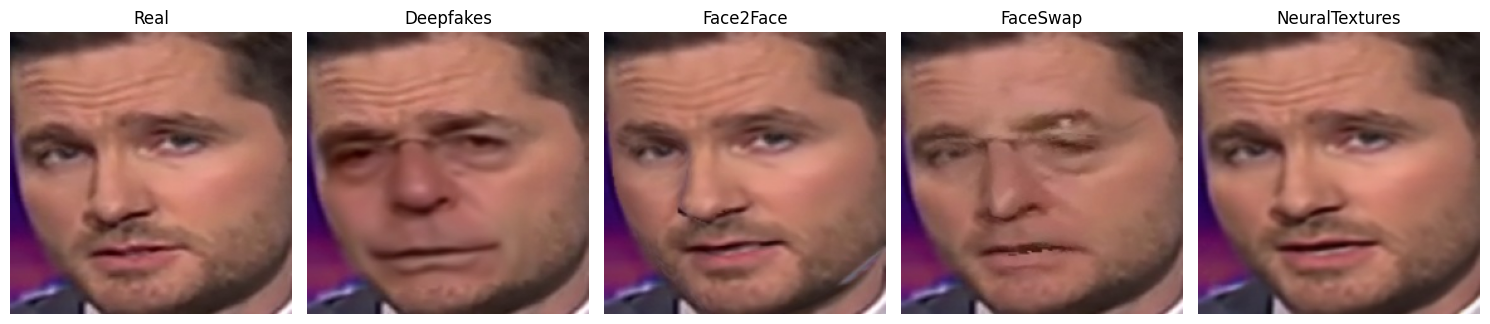

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def get_one_image_from_each_video(folder):
    """Get the first available frame from each video directory."""
    video_dirs = sorted(Path(folder).glob("*"))
    for video_dir in video_dirs:
        if video_dir.is_dir():
            frames = sorted(video_dir.glob("*.jpg"))
            if frames:
                return str(frames[0])
    return None

def display_real_vs_fakes(base_dir, fake_folders):
    images = []

    # Get one real image
    real_image_path = get_one_image_from_each_video(os.path.join(base_dir, 'real'))
    if real_image_path:
        images.append(('Real', real_image_path))

    # Get one fake image from each fake folder
    for fake_type in fake_folders:
        fake_folder_path = os.path.join(base_dir, 'fake', fake_type)
        fake_image_path = get_one_image_from_each_video(fake_folder_path)
        if fake_image_path:
            images.append((fake_type, fake_image_path))

    # Plot all images
    plt.figure(figsize=(len(images) * 3, 4))
    for i, (label, img_path) in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
ff_base_dir = "/content/drive/MyDrive/dataset/processed/faceforensics"
ff_fake_folders = ['Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures']

display_real_vs_fakes(ff_base_dir, ff_fake_folders)

#### Gather all image paths and assign labels (FaceForensics++)

In this step, loop through the processed dataset directory to collect the file paths of all cropped face images. Each image is assigned a label — `0` for real faces and `1` for fake faces (regardless of manipulation type). These `(image_path, label)` pairs will be used to load and prepare the dataset for training and evaluation.


In [ ]:
def gather_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    # Real images
    ff_real_dir = Path(base_dir) / 'real'
    for video_folder in ff_real_dir.glob("*"):
        for img_path in video_folder.glob("*.jpg"):
            image_paths.append(str(img_path))
            labels.append(0)  # Label 0 for real

    # Fake images
    ff_fake_base_dir = Path(base_dir) / 'fake'
    for fake_type_dir in ff_fake_base_dir.glob("*"):  # e.g., Deepfakes, Face2Face, etc.
        for video_folder in fake_type_dir.glob("*"):
            for img_path in video_folder.glob("*.jpg"):
                image_paths.append(str(img_path))
                labels.append(1)  # Label 1 for all fakes

    return image_paths, labels

In [ ]:
from collections import Counter

ff_base_dir = "/content/drive/MyDrive/dataset/processed/faceforensics"
ff_image_paths, ff_labels = gather_image_paths_and_labels(ff_base_dir)

print("Label distribution:", Counter(ff_labels))

print(f"Total images collected: {len(ff_image_paths)}")
print(f"Sample: {ff_image_paths[0]}, Label: {ff_labels[0]}")

Label distribution: Counter({1: 10000, 0: 2500})
Total images collected: 12500
Sample: /content/drive/MyDrive/dataset/processed/faceforensics/real/585/frame_00000.jpg, Label: 0


### Preprocess DFDC Dataset

In [ ]:
from retina_face_extraction import RetinaFacePreprocessor
import os
import shutil

# Set input/output paths
dfdc_input_dir = '/content/drive/MyDrive/dataset/dfdc/structured_dfdc'
dfdc_output_dir = '/content/drive/MyDrive/dataset/processed/dfdc'
real_dir = os.path.join(dfdc_output_dir, "real")
fake_dir = os.path.join(dfdc_output_dir, "fake")

# === Early Exit Check ===
if os.path.exists(real_dir) and os.path.exists(fake_dir):
    if len(os.listdir(real_dir)) > 0 and len(os.listdir(fake_dir)) > 0:
        print("Preprocessing already done — skipping.")
    else:
        print("Output folder exists but is empty — proceeding with preprocessing.")
        # Optionally clean up incomplete run
        shutil.rmtree(dfdc_output_dir)
        os.makedirs(dfdc_output_dir)

        dfdc_processor = RetinaFacePreprocessor(dfdc_input_dir, dfdc_output_dir, dataset_type="dfdc")
        dfdc_processor.run()
else:
    print("Starting preprocessing.")
    os.makedirs(dfdc_output_dir, exist_ok=True)
    dfdc_processor = RetinaFacePreprocessor(dfdc_input_dir, dfdc_output_dir, dataset_type="dfdc")
    dfdc_processor.run()

Starting preprocessing.
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExe

100%|██████████| 83/83 [03:53<00:00,  2.81s/it]



Processing FAKE from /content/drive/MyDrive/dataset/dfdc/structured_dfdc/fake (1170 videos)


100%|██████████| 1170/1170 [41:18<00:00,  2.12s/it]


#### Display Sample Image from Preprocessed DFDC Dataset

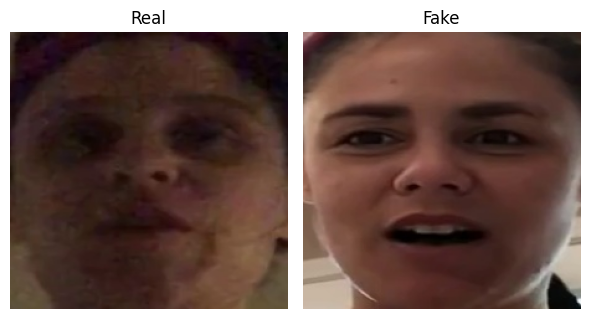

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def get_one_image_from_each_video(folder):
    """Get the first available frame from each video directory."""
    video_dirs = sorted(Path(folder).glob("*"))
    for video_dir in video_dirs:
        if video_dir.is_dir():
            frames = sorted(video_dir.glob("*.jpg"))
            if frames:
                return str(frames[0])
    return None

def display_dfdc_real_vs_fake(base_dir):
    images = []

    # One real image
    real_image_path = get_one_image_from_each_video(os.path.join(base_dir, 'real'))
    if real_image_path:
        images.append(('Real', real_image_path))
    else:
        print("[!] No real images found.")

    # One fake image
    fake_image_path = get_one_image_from_each_video(os.path.join(base_dir, 'fake'))
    if fake_image_path:
        images.append(('Fake', fake_image_path))
    else:
        print("[!] No fake images found.")

    # Plot images
    if images:
        plt.figure(figsize=(len(images) * 3, 4))
        for i, (label, img_path) in enumerate(images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(images), i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("[!] No images to display.")

# Example usage
dfdc_base_dir = "/content/drive/MyDrive/dataset/processed/dfdc"
display_dfdc_real_vs_fake(dfdc_base_dir)

#### Gather all image paths and assign labels (DFDC)

In this step, loop through the processed dataset directory to collect the file paths of all cropped face images. Each image is assigned a label — 0 for real faces and 1 for fake faces. These (image_path, label) pairs will be used to load and prepare the dataset for training and evaluation.

In [ ]:
from pathlib import Path

def gather_dfdc_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    # Real images
    dfdc_real_dir = Path(base_dir) / 'real'
    for video_folder in dfdc_real_dir.glob("*"):
        for img_path in video_folder.glob("*.jpg"):
            image_paths.append(str(img_path))
            labels.append(0)  # Label 0 for real

    # Fake images
    dfdc_fake_dir = Path(base_dir) / 'fake'
    for video_folder in dfdc_fake_dir.glob("*"):
        for img_path in video_folder.glob("*.jpg"):
            image_paths.append(str(img_path))
            labels.append(1)  # Label 1 for fake

    return image_paths, labels

In [ ]:
from collections import Counter

dfdc_base_dir = "/content/drive/MyDrive/dataset/processed/dfdc"
dfdc_image_paths, dfdc_labels = gather_dfdc_image_paths_and_labels(dfdc_base_dir)

print("Label distribution:", Counter(dfdc_labels))

print(f"Total images collected: {len(dfdc_image_paths)}")
print(f"Sample: {dfdc_image_paths[0]}, Label: {dfdc_labels[0]}")

Label distribution: Counter({1: 11690, 0: 830})
Total images collected: 12520
Sample: /content/drive/MyDrive/dataset/processed/dfdc/real/aayrffkzxn/frame_00000.jpg, Label: 0


### Custom PyTorch Datasets

This custom `DeepfakeDataset` class is built to efficiently load deepfake images and their labels for training a PyTorch model. It takes image file paths and corresponding labels, loads each image in RGB format, applies optional transformations (like resizing or normalization), and returns the processed image along with its label as a tensor. This setup is essential when working with non-standard datasets, giving you full control over data loading and preprocessing while enabling seamless integration with PyTorch's `DataLoader` for efficient training.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import numpy as np

# ----- Dataset -----
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
ff_dataset = DeepfakeDataset(ff_image_paths, ff_labels, transform=None)
dfdc_dataset = DeepfakeDataset(dfdc_image_paths, dfdc_labels, transform=None)

#### Splitting both Dataset into Train, Validation, and Test Sets

This code splits the full dataset into training, validation, and test sets. It divides the data into 70% for training, 15% for validation, and 15% for testing, ensuring that the split is reproducible by setting a random seed. This is important for evaluating model performance fairly and preventing data leakage between sets during deepfake model training.

In [ ]:
import random
from torch.utils.data import Subset
from tqdm import tqdm

def reduce_class(dataset, majority_class=1, minority_class=0, ratio=1.5, seed=42):
    random.seed(seed)

    print("Scanning dataset labels to collect class indices...")

    # Add tqdm for progress visualization
    majority_indices = []
    minority_indices = []

    for i in tqdm(range(len(dataset)), desc="Indexing"):
        label = int(dataset.labels[i])
        if label == majority_class:
            majority_indices.append(i)
        elif label == minority_class:
            minority_indices.append(i)

    # Limit majority class size
    desired_majority_count = int(len(minority_indices) * ratio)
    reduced_majority_indices = random.sample(majority_indices, desired_majority_count)

    # Combine and shuffle
    combined_indices = reduced_majority_indices + minority_indices
    random.shuffle(combined_indices)

    print(f"Reduced majority class from {len(majority_indices)} to {desired_majority_count}")
    print(f"Minority class count remains: {len(minority_indices)}")
    print(f"Total samples after reduction: {len(combined_indices)}")

    return Subset(dataset, combined_indices)

In [ ]:
ff_balanced_dataset = reduce_class(ff_dataset)

dfdc_balanced_dataset = reduce_class(dfdc_dataset)

Scanning dataset labels to collect class indices...


Indexing: 100%|██████████| 12500/12500 [00:00<00:00, 3152284.75it/s]


Reduced majority class from 10000 to 3750
Minority class count remains: 2500
Total samples after reduction: 6250
Scanning dataset labels to collect class indices...


Indexing: 100%|██████████| 12520/12520 [00:00<00:00, 3177579.94it/s]

Reduced majority class from 11690 to 1245
Minority class count remains: 830
Total samples after reduction: 2075


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from tqdm import tqdm
import numpy as np

def stratified_split(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42, verbose=True):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    print("Preparing stratified data splits...")

    # Unwrap if Subset
    if isinstance(dataset, Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
        print("Extracting labels from Subset...")
        labels = [base_dataset.labels[i] for i in tqdm(indices, desc="Extracting labels")]
    else:
        base_dataset = dataset
        indices = list(range(len(dataset)))
        labels = base_dataset.labels

    # First split: Train vs Temp
    print("Splitting: Train vs (Val + Test)")
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1.0 - train_ratio), random_state=seed)
    train_idx, temp_idx = next(sss1.split(X=indices, y=labels))

    train_indices = [indices[i] for i in train_idx]
    temp_indices = [indices[i] for i in temp_idx]
    temp_labels = [labels[i] for i in temp_idx]

    # Second split: Val vs Test
    print("Splitting: Val vs Test")
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - val_ratio_adjusted), random_state=seed)
    val_idx, test_idx = next(sss2.split(X=temp_indices, y=temp_labels))

    val_indices = [temp_indices[i] for i in val_idx]
    test_indices = [temp_indices[i] for i in test_idx]

    print(f"\nFinal split sizes:")
    print(f" - Train: {len(train_indices)}")
    print(f" - Val:   {len(val_indices)}")
    print(f" - Test:  {len(test_indices)}")

    # Optional: print class distribution
    if verbose:
        for name, idxs in zip(["Train", "Val", "Test"], [train_indices, val_indices, test_indices]):
            split_labels = [base_dataset.labels[i] for i in idxs]
            classes, counts = np.unique(split_labels, return_counts=True)
            dist = ", ".join([f"{cls}: {cnt}" for cls, cnt in zip(classes, counts)])
            print(f" - {name} Class Distribution → {dist}")

    return Subset(base_dataset, train_indices), Subset(base_dataset, val_indices), Subset(base_dataset, test_indices)

In [ ]:
ff_train, ff_val, ff_test = stratified_split(ff_balanced_dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

print()

dfdc_train, dfdc_val, dfdc_test = stratified_split(dfdc_balanced_dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Preparing stratified data splits...
Extracting labels from Subset...


Extracting labels: 100%|██████████| 6250/6250 [00:00<00:00, 2889912.91it/s]


Splitting: Train vs (Val + Test)
Splitting: Val vs Test

Final split sizes:
 - Train: 4374
 - Val:   938
 - Test:  938
 - Train Class Distribution → 0: 1750, 1: 2624
 - Val Class Distribution → 0: 375, 1: 563
 - Test Class Distribution → 0: 375, 1: 563

Preparing stratified data splits...
Extracting labels from Subset...


Extracting labels: 100%|██████████| 2075/2075 [00:00<00:00, 2643736.57it/s]

Splitting: Train vs (Val + Test)
Splitting: Val vs Test

Final split sizes:
 - Train: 1452
 - Val:   311
 - Test:  312
 - Train Class Distribution → 0: 581, 1: 871
 - Val Class Distribution → 0: 124, 1: 187
 - Test Class Distribution → 0: 125, 1: 187


In [ ]:
from collections import Counter

def check_label_distribution(dataset, subset):
    try:
        labels = [dataset.labels[i] for i in subset.indices]
    except AttributeError:
        labels = [dataset[i][1] for i in subset.indices]  # fallback (slower)
    return Counter(labels)

print("FaceForensics++ Split: ")
print("Train:", check_label_distribution(ff_dataset, ff_train))
print("Val:  ", check_label_distribution(ff_dataset, ff_val))
print("Test: ", check_label_distribution(ff_dataset, ff_test))

print()
print("DFDC Split: ")
print("Train:", check_label_distribution(dfdc_dataset, dfdc_train))
print("Val:  ", check_label_distribution(dfdc_dataset, dfdc_val))
print("Test: ", check_label_distribution(dfdc_dataset, dfdc_test))

FaceForensics++ Split: 
Train: Counter({1: 2624, 0: 1750})
Val:   Counter({1: 563, 0: 375})
Test:  Counter({1: 563, 0: 375})

DFDC Split: 
Train: Counter({1: 871, 0: 581})
Val:   Counter({1: 187, 0: 124})
Test:  Counter({1: 187, 0: 125})


#### Image Transforms for Training and Evaluation (both dataset)

This code defines two sets of image transformations: one for training data that includes resizing, random horizontal flipping, color jittering, tensor conversion, and normalization to help the model generalize better by augmenting the images; and another simpler set for validation and test data that only resizes, converts to tensor, and normalizes. These transforms are then applied to the respective dataset splits to ensure consistent preprocessing during training and evaluation.

In [ ]:
from torchvision import transforms
from torch.utils.data import Subset

def apply_transforms(train_ds, val_ds, test_ds,
                     train_size=(224, 224), val_test_size=(224, 224)):

    train_transform = transforms.Compose([
        transforms.Resize(train_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(val_test_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Helper to set transform on the base dataset, even if wrapped in Subset
    def set_transform(dataset, transform):
        base_ds = dataset
        while isinstance(base_ds, Subset):
            base_ds = base_ds.dataset
        base_ds.transform = transform
        return dataset

    train_ds = set_transform(train_ds, train_transform)
    val_ds = set_transform(val_ds, val_test_transform)
    test_ds = set_transform(test_ds, val_test_transform)

    return train_ds, val_ds, test_ds

In [ ]:
# transformed Faceforensics++ Dataset
ff_train_transformed, ff_val_transformed, ff_test_transformed = apply_transforms(
    ff_train, ff_val, ff_test
)

# transformed DFDC Dataset
dfdc_train_transformed, dfdc_val_transformed, dfdc_test_transformed = apply_transforms(
    dfdc_train, dfdc_val, dfdc_test
)

#### DataLoader Setup and Batch Retrieval

In this project, the DataLoader is configured to ensure fair, balanced, and efficient training for both the FaceForensics++ and DFDC datasets. Since the dataset contains a significant class imbalance (e.g., many more fake videos than real ones), a `WeightedRandomSampler` is used during training. This sampling strategy ensures that the model sees an approximately equal number of real and fake samples in each batch, helping to prevent bias toward the majority class.


In [ ]:
def create_weighted_sampler(dataset):
    original_dataset = dataset.dataset if isinstance(dataset, Subset) else dataset
    indices = dataset.indices if isinstance(dataset, Subset) else list(range(len(original_dataset)))

    # FAST: Direct access to stored labels
    labels = [original_dataset.labels[i] for i in indices]

    classes, counts = np.unique(labels, return_counts=True)
    class_weights = 1. / counts
    samples_weight = np.array([class_weights[classes.tolist().index(l)] for l in labels])
    samples_weight = torch.from_numpy(samples_weight).double()
    return WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
def prepare_dataloaders(train_ds, val_ds, test_ds, batch_size=64, use_sampler=False):
    def create_sampler(dataset):
        original_dataset = dataset.dataset if isinstance(dataset, Subset) else dataset
        indices = dataset.indices if isinstance(dataset, Subset) else list(range(len(original_dataset)))

        # FAST: Direct access to stored labels
        labels = [original_dataset.labels[i] for i in indices]

        classes, counts = np.unique(labels, return_counts=True)
        class_weights = 1. / counts
        sample_weights = [class_weights[classes.tolist().index(l)] for l in labels]
        return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_sampler = create_sampler(train_ds) if use_sampler else None

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=(train_sampler is None), sampler=train_sampler, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

In [ ]:
# ----DataLoader for FaceForensics++ Dataset
ff_train_loader, ff_val_loader, ff_test_loader = prepare_dataloaders(
    ff_train_transformed,
    ff_val_transformed,
    ff_test_transformed,
    use_sampler=True
    )

# # Get a single batch from FF++ train loader
ff_images_batch, ff_labels_batch = next(iter(ff_train_loader))
print("FF++ Batch Image Shape:", ff_images_batch.shape)
print("FF++ Batch Label Shape:", ff_labels_batch.shape)


print("====================================================================")
# ---DataLoader for DFDC Dataset
dfdc_train_loader, dfdc_val_loader, dfdc_test_loader = prepare_dataloaders(
    dfdc_train_transformed,
    dfdc_val_transformed,
    dfdc_test_transformed,
    use_sampler=True
    )

dfdc_images_batch, dfdc_labels_batch = next(iter(dfdc_train_loader))
print("DFDC Batch Image Shape:", dfdc_images_batch.shape)
print("DFDC Batch Label Shape:", dfdc_labels_batch.shape)

FF++ Batch Image Shape: torch.Size([64, 3, 224, 224])
FF++ Batch Label Shape: torch.Size([64])
DFDC Batch Image Shape: torch.Size([64, 3, 224, 224])
DFDC Batch Label Shape: torch.Size([64])


In [ ]:
from collections import Counter

ff_labels_batch = ff_labels_batch.numpy()
print("FF++ Batch Label Distribution:", Counter(ff_labels_batch))

dfdc_labels_batch = dfdc_labels_batch.numpy()
print("DFDC Batch Label Distribution:", Counter(dfdc_labels_batch))


FF++ Batch Label Distribution: Counter({np.int64(0): 36, np.int64(1): 28})
DFDC Batch Label Distribution: Counter({np.int64(0): 37, np.int64(1): 27})


In [ ]:
import numpy as np

def check_split_balance(subset, name="Subset"):
    original_dataset = subset.dataset
    indices = subset.indices

    labels = [original_dataset.labels[i] for i in indices]

    # Count class distribution
    unique, counts = np.unique(labels, return_counts=True)
    total = len(labels)

    print(f"\n{name} - Total: {total}")
    for label, count in zip(unique, counts):
        label_name = "Real" if label == 0 else "Fake"
        print(f"{label_name}: {count} ({count/total:.2%})")


print("FaceForensics++ Dataset")
check_split_balance(ff_train, "FaceForensics++ Train")
check_split_balance(ff_val, "FaceForensics++ Val")
check_split_balance(ff_test, "FaceForensics++ Test")

print()
print("====================================================================")
print("DFDC Dataset")
check_split_balance(dfdc_train, "DFDC Train")
check_split_balance(dfdc_val, "DFDC Val")
check_split_balance(dfdc_test, "DFDC Test")

FaceForensics++ Dataset

FaceForensics++ Train - Total: 4374
Real: 1750 (40.01%)
Fake: 2624 (59.99%)

FaceForensics++ Val - Total: 938
Real: 375 (39.98%)
Fake: 563 (60.02%)

FaceForensics++ Test - Total: 938
Real: 375 (39.98%)
Fake: 563 (60.02%)

DFDC Dataset

DFDC Train - Total: 1452
Real: 581 (40.01%)
Fake: 871 (59.99%)

DFDC Val - Total: 311
Real: 124 (39.87%)
Fake: 187 (60.13%)

DFDC Test - Total: 312
Real: 125 (40.06%)
Fake: 187 (59.94%)


## Pretrained Model: XceptionNet

### XceptionModel

#### Load Pretrained XceptionNet

In [ ]:
import timm

# Load XceptionNet from timm
xception_model = timm.create_model('xception', pretrained=True)

# Modify the classifier for binary classification (real vs fake)
num_ftrs = xception_model.fc.in_features
xception_model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


#### Define Loss, Optimizer & Scheduler

In [ ]:
xception_model_criterion = nn.CrossEntropyLoss()
xception_model_optimizer = torch.optim.Adam(xception_model.parameters(), lr=1e-4)
xception_model_scheduler = torch.optim.lr_scheduler.StepLR(xception_model_optimizer, step_size=5, gamma=0.5)

#### Training Loop

In [ ]:
from tqdm import tqdm

def train_xception_model(model, train_loader, optimizer, criterion, scheduler, device, num_epochs=10):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

#### Evaluatation of XceptionNet

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import torch.nn.functional as F

def evaluate_xception_model(model, loader, device, use_logits=True):
    model.eval()
    all_preds = []
    all_probs = []  # for AUC
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # raw logits or outputs before softmax
            probs = torch.softmax(outputs, dim=1)[:, 1]  # prob for class 1 (real)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        # AUC can't be calculated if only one class present in labels
        auc = float('nan')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    }

    return metrics

#### Confusion Matrix of XceptionNet

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix_xception(model, loader, device, title="Confusion Matrix"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

#### ROC Curve

In [ ]:
def plot_roc_curve(model, dataloader):
    model.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # If outputs are logits of shape [batch_size, 2], use softmax and take class 1
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1

            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Ensure y_true is 1D
    y_true = np.array(y_true).flatten()

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### FaceForensics++ on XceptionNet Model

In [ ]:
# training
train_xception_model(
    xception_model,
    ff_train_loader,
    xception_model_optimizer,
    xception_model_criterion,
    xception_model_scheduler,
    device,
    num_epochs=10
    )

Epoch [1/10], Avg Loss: 0.2810


Epoch [2/10], Avg Loss: 0.0352


Epoch [3/10], Avg Loss: 0.0254


Epoch [4/10], Avg Loss: 0.0118


Epoch [5/10], Avg Loss: 0.0108


Epoch [6/10], Avg Loss: 0.0072


Epoch [7/10], Avg Loss: 0.0048


Epoch [8/10], Avg Loss: 0.0029


Epoch [9/10], Avg Loss: 0.0019


Epoch [10/10], Avg Loss: 0.0013


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/deepfake_models", exist_ok=True)

save_path = "/content/drive/MyDrive/deepfake_models/xception_model_ffpp.pth"

In [ ]:
torch.save(xception_model.state_dict(), save_path)

In [ ]:
xception_model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/xception_model_ffpp.pth"))
xception_model = xception_model.to(device)

In [ ]:
ff_train_metrics = evaluate_xception_model(xception_model, ff_train_loader, device)

print("Evaluation Metrics on Training (FaceForensics++):")
for k, v in ff_train_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

print()

ff_val_metrics = evaluate_xception_model(xception_model, ff_val_loader, device)

print("Evaluation Metrics on Validation (FaceForensics++):")
for k, v in ff_val_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Training (FaceForensics++):
Accuracy: 0.9991
Precision: 1.0000
Recall: 0.9982
F1_score: 0.9991
Auc_roc: 1.0000



Evaluation Metrics on Validation (FaceForensics++):
Accuracy: 0.9947
Precision: 1.0000
Recall: 0.9911
F1_score: 0.9955
Auc_roc: 0.9997


In [ ]:
# evaluation of testing set
ff_test_metrics = evaluate_xception_model(xception_model, ff_test_loader, device)

print("Evaluation Metrics on Testing (FaceForensics++):")
for k, v in ff_test_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Testing (FaceForensics++):
Accuracy: 0.9936
Precision: 0.9982
Recall: 0.9911
F1_score: 0.9947
Auc_roc: 0.9998


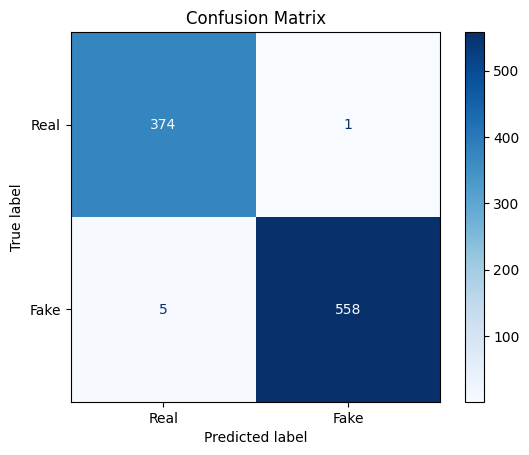

In [ ]:
# confusion matrix
plot_conf_matrix_xception(xception_model, ff_test_loader, device)

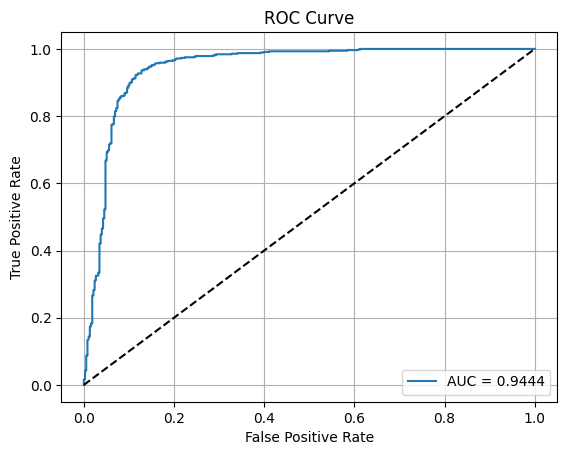

In [ ]:
# ROC curve
plot_roc_curve(xception_model, ff_test_loader)

### DFDC on XceptionNet Model

In [ ]:
# training
train_xception_model(
    xception_model,
    dfdc_train_loader,
    xception_model_optimizer,
    xception_model_criterion,
    xception_model_scheduler,
    device,
    num_epochs=5
    )

Epoch [1/5], Avg Loss: 0.7327


Epoch [2/5], Avg Loss: 0.3201


Epoch [3/5], Avg Loss: 0.1565


Epoch [4/5], Avg Loss: 0.0682


Epoch [5/5], Avg Loss: 0.0312


In [ ]:
# evaluation on Training and Testing
dfdc_train_metrics = evaluate_xception_model(xception_model, dfdc_train_loader, device)

print("Evaluation Metrics on Training (DFDC):")
for k, v in dfdc_train_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

print()

dfdc_val_metrics = evaluate_xception_model(xception_model, dfdc_val_loader, device)

print("Evaluation Metrics on Validation (DFDC):")
for k, v in dfdc_val_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Training (DFDC):
Accuracy: 0.9924
Precision: 0.9944
Recall: 0.9903
F1_score: 0.9924
Auc_roc: 0.9998



Evaluation Metrics on Validation (DFDC):
Accuracy: 0.8939
Precision: 0.9010
Recall: 0.9251
F1_score: 0.9129
Auc_roc: 0.9617


In [ ]:
# evaluation of testing set
dfdc_test_metrics = evaluate_xception_model(xception_model, dfdc_test_loader, device)

print("Evaluation Metrics on Testing (DFDC):")
for k, v in dfdc_test_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Testing (DFDC):
Accuracy: 0.8558
Precision: 0.8777
Recall: 0.8824
F1_score: 0.8800
Auc_roc: 0.9339


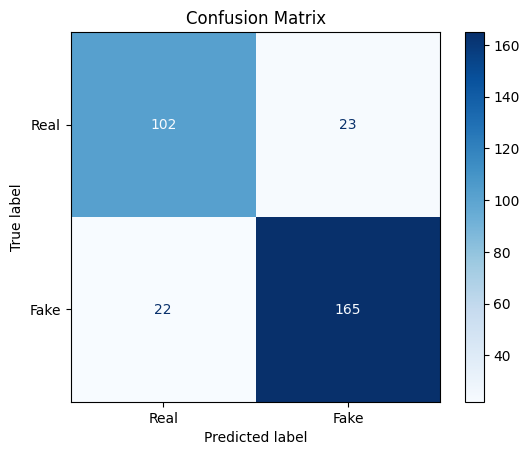

In [ ]:
# confusion matrix
plot_conf_matrix_xception(xception_model, dfdc_test_loader, device)

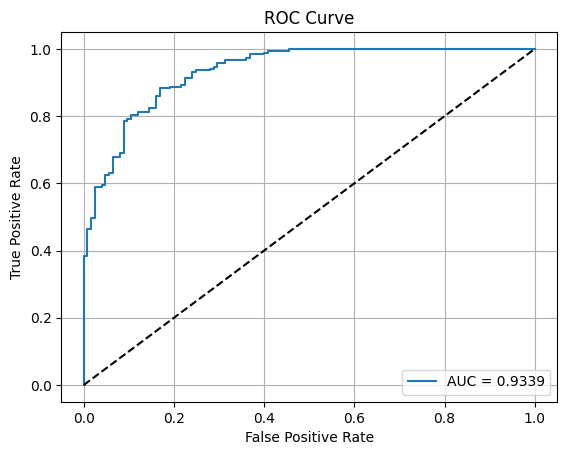

In [ ]:
# ROC Curve
plot_roc_curve(xception_model, dfdc_test_loader)

## Model: MesoInception4

### MesoModel

#### Meso4 Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.branch5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.bn = nn.BatchNorm2d(out_channels * 3)

    def forward(self, x):
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        out = torch.cat([b1, b3, b5], dim=1)
        out = self.bn(out)
        return F.relu(out)

class MesoInception4(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial conv layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )

        # Inception blocks
        self.inception3 = InceptionBlock(32, 32)   # output: 32*3=96
        self.inception4 = InceptionBlock(96, 64)   # output: 64*3=192

        # Residual connection after inception4
        self.residual_conv = nn.Conv2d(96, 192, kernel_size=1)  # fix mismatch

        # Global pooling and FC
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, 1)   # BCEWithLogitsLoss compatible
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        x = self.inception3(x)
        residual = self.residual_conv(x)
        x = self.inception4(x)
        x = x + residual
        x = F.relu(x)

        x = self.global_pool(x)
        x = self.fc(x)
        return x.squeeze(1)  # [batch]

#### Optimizer, criterion for MesoNet

In [ ]:
meso_model = MesoInception4().to(device)
meso_criterion = nn.BCEWithLogitsLoss()
meso_optimizer = torch.optim.Adam(meso_model.parameters(), lr=1e-4, weight_decay=1e-5)
meso_scheduler = torch.optim.lr_scheduler.StepLR(meso_optimizer, step_size=5, gamma=0.5)

#### Train Meso4 Model

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_meso_model(model, train_loader, optimizer, scheduler, device, num_epochs=10):
    model = model.to(device)

    # Compute pos_weight for BCEWithLogitsLoss
    labels_list = []
    for _, labels in train_loader:
        labels_list.append(labels)
    labels_all = torch.cat(labels_list)
    num_pos = (labels_all == 1).sum()
    num_neg = (labels_all == 0).sum()
    pos_weight = (num_neg / num_pos).to(device)

    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device).float().view(-1)  # [batch_size]

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda' if device.startswith('cuda') else 'cpu'):
                outputs = model(images).view(-1)  # [batch_size]
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.4f}")

#### Evaluate MesoModel

In [ ]:
def evaluate_meso_model(model, loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.6).long()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float('nan')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    }

    return metrics

#### Confusion Matrix of MesoNet

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix_meso(model, loader, device, title="Confusion Matrix"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = (outputs > 0.6).long()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

### FaceForensics++ on MesoNet Model

In [ ]:
# training
train_meso_model(
    meso_model,
    ff_train_loader,
    meso_optimizer,
    meso_scheduler,
    device,
    num_epochs=30
    )

Epoch [1/30] Train Loss: 0.6836


Epoch [2/30] Train Loss: 0.6847


Epoch [3/30] Train Loss: 0.6850


Epoch [4/30] Train Loss: 0.6888


Epoch [5/30] Train Loss: 0.6859


Epoch [6/30] Train Loss: 0.6837


Epoch [7/30] Train Loss: 0.6836


Epoch [8/30] Train Loss: 0.6832


Epoch [9/30] Train Loss: 0.6838


Epoch [10/30] Train Loss: 0.6833


Epoch [11/30] Train Loss: 0.6804


Epoch [12/30] Train Loss: 0.6772


Epoch [13/30] Train Loss: 0.6823


Epoch [14/30] Train Loss: 0.6855


Epoch [15/30] Train Loss: 0.6838


Epoch [16/30] Train Loss: 0.6802


Epoch [17/30] Train Loss: 0.6797


Epoch [18/30] Train Loss: 0.6812


Epoch [19/30] Train Loss: 0.6826


Epoch [20/30] Train Loss: 0.6811


Epoch [21/30] Train Loss: 0.6811


Epoch [22/30] Train Loss: 0.6813


Epoch [23/30] Train Loss: 0.6828


Epoch [24/30] Train Loss: 0.6883


Epoch [25/30] Train Loss: 0.6820


Epoch [26/30] Train Loss: 0.6861


Epoch [27/30] Train Loss: 0.6831


Epoch [28/30] Train Loss: 0.6791


Epoch [29/30] Train Loss: 0.6873


Epoch [30/30] Train Loss: 0.6875


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/deepfake_models", exist_ok=True)

save_path = "/content/drive/MyDrive/deepfake_models/meso_model_ffpp.pth"

torch.save(meso_model.state_dict(), save_path)

In [ ]:
meso_model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/meso_model_ffpp.pth"))
meso_model = meso_model.to(device)

In [ ]:
ff_train_metrics = evaluate_meso_model(meso_model, ff_train_loader, device)

print("Evaluation Metrics on Training (FaceForensics++):")
for k, v in ff_train_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

print()

ff_val_metrics = evaluate_meso_model(meso_model, ff_val_loader, device)

print("Evaluation Metrics on Validation (FaceForensics++):")
for k, v in ff_val_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Training (FaceForensics++):
Accuracy: 0.5729
Precision: 0.6052
Recall: 0.4252
F1_score: 0.4995
Auc_roc: 0.6122



Evaluation Metrics on Validation (FaceForensics++):
Accuracy: 0.5107
Precision: 0.6444
Recall: 0.4121
F1_score: 0.5027
Auc_roc: 0.5693


In [ ]:
# evaluation of testing set
ff_test_metrics = evaluate_meso_model(meso_model, ff_test_loader, device)

print("Evaluation Metrics on Testing (FaceForensics++):")
for k, v in ff_test_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Testing (FaceForensics++):
Accuracy: 0.5426
Precision: 0.6872
Recall: 0.4369
F1_score: 0.5342
Auc_roc: 0.6048


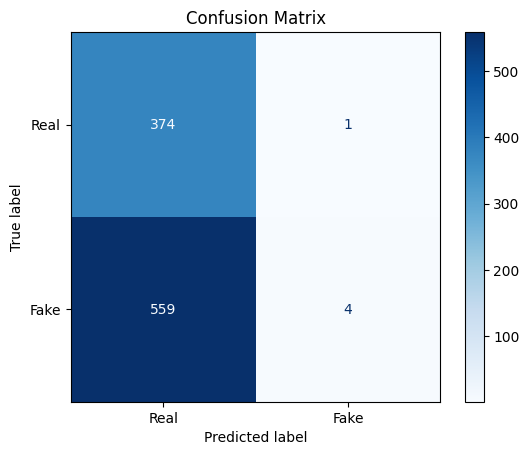

In [ ]:
# confusion matrix
plot_conf_matrix_meso(meso_model, ff_test_loader, device)

### DFDC on MesoNet Model

In [ ]:
# # training
# train_meso_model(
#     meso_model,
#     dfdc_train_loader,
#     meso_optimizer,
#     meso_criterion,
#     meso_scheduler,
#     device,
#     num_epochs=10
#     )

In [ ]:
# evaluating
dfdc_train_metrics = evaluate_meso_model(meso_model, dfdc_train_loader, device)

print("Evaluation Metrics on Training (DFDC):")
for k, v in dfdc_train_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

print()

dfdc_val_metrics = evaluate_meso_model(meso_model, dfdc_val_loader, device)

print("Evaluation Metrics on Validation (DFDC):")
for k, v in dfdc_val_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Training (DFDC):
Accuracy: 0.5393
Precision: 0.5178
Recall: 0.8792
F1_score: 0.6517
Auc_roc: 0.6180



Evaluation Metrics on Validation (DFDC):
Accuracy: 0.5852
Precision: 0.6124
Recall: 0.8449
F1_score: 0.7101
Auc_roc: 0.5875


In [ ]:
# evaluation of testing set
dfdc_test_metrics = evaluate_meso_model(meso_model, dfdc_test_loader, device)

print("Evaluation Metrics on Testing (DFDC):")
for k, v in dfdc_test_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Evaluation Metrics on Testing (DFDC):
Accuracy: 0.6378
Precision: 0.6350
Recall: 0.9305
F1_score: 0.7549
Auc_roc: 0.6261


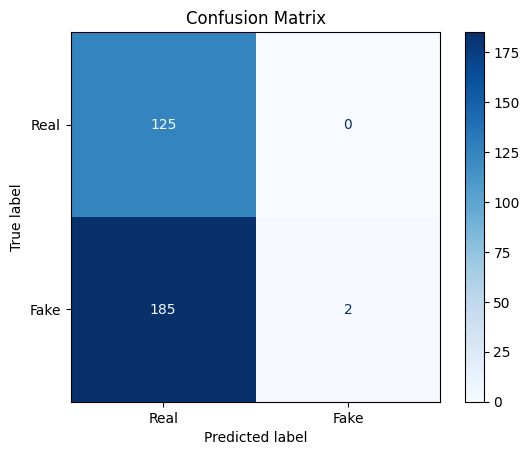

In [ ]:
# confusion matrix
plot_conf_matrix_meso(meso_model, dfdc_test_loader, device)

## Custom Model

#### Model Architecture

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

# --- Attention-based pooling layer ---
class AttentionPool(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        B, C, H, W = x.size()
        attn_map = self.attn(x)  # (B, 1, H, W)
        weighted = x * attn_map  # (B, C, H, W)
        return weighted.view(B, C, -1).sum(dim=-1)  # (B, C)

# --- Hybrid CNN + ViT Deepfake Detector ---
class HybridDeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN Branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # (B, 64, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 64, 112, 112)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 128, 56, 56)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
            # Output: (B, 256, 56, 56)
        )
        self.cnn_pool = AttentionPool(in_channels=256)  # → (B, 256)

        # Vision Transformer Branch
        self.vit = vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove classification head → (B, 768)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)  # Raw logits for BCEWithLogitsLoss
        )

    def forward(self, x):
        cnn_feat = self.cnn_branch(x)         # (B, 256, 56, 56)
        cnn_feat = self.cnn_pool(cnn_feat)    # (B, 256)

        vit_feat = self.vit(x)                # (B, 768)

        combined = torch.cat((cnn_feat, vit_feat), dim=1)  # (B, 1024)
        out = self.classifier(combined)       # (B, 1) → logits
        return out

In [ ]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = HybridDeepfakeDetector().to(device)

# Print model summary
print(summary(model, input_size=(1, 3, 224, 224)));

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 199MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
HybridDeepfakeDetector                             [1, 1]                    --
├─Sequential: 1-1                                  [1, 256, 56, 56]          --
│    └─Conv2d: 2-1                                 [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                                   [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                              [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                                 [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                                   [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                              [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                                 [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                                   [1, 256, 56, 56]          --
├─AttentionPool: 1-2                               [1, 256]                  --
│    └─Sequential: 2-9 

#### Define Loss, Optimizer, Scheduler, EarlyStopping

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function (with label smoothing for generalization)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.9]).to(device))

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Scheduler (reduces LR on plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), "/content/drive/MyDrive/deepfake_models/best_model.pth");

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### Training Loop

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5, device='cuda'):
    early_stopping = EarlyStopping(patience=patience)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_losses.append(loss.item())
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        avg_val_loss = sum(val_losses) / len(val_losses)
        all_preds_bin = (torch.tensor(all_preds) > 0.5).int().numpy()
        all_targets_bin = torch.tensor(all_targets).int().numpy()

        acc = accuracy_score(all_targets_bin, all_preds_bin)
        prec = precision_score(all_targets_bin, all_preds_bin)
        rec = recall_score(all_targets_bin, all_preds_bin)
        f1 = f1_score(all_targets_bin, all_preds_bin)
        auc = roc_auc_score(all_targets_bin, all_preds)

        print(f"Validation Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model...")
            break

    # Load the best model
    model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/best_model.pth"))
    return model

In [ ]:
train_model(model, ff_train_loader, ff_val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=5, device='cuda');

Epoch 1/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [1/30], Train Loss: 0.5569


Validation Loss: 0.3413 | Acc: 0.8635 | Prec: 0.8976 | Rec: 0.8721 | F1: 0.8847 | AUC: 0.9296


Epoch 2/30: 100%|██████████| 69/69 [01:21<00:00,  1.18s/it]

Epoch [2/30], Train Loss: 0.2010


Validation Loss: 0.2057 | Acc: 0.9041 | Prec: 0.9778 | Rec: 0.8597 | F1: 0.9149 | AUC: 0.9786


Epoch 3/30: 100%|██████████| 69/69 [01:21<00:00,  1.19s/it]

Epoch [3/30], Train Loss: 0.0878


Validation Loss: 0.1369 | Acc: 0.9456 | Prec: 0.9776 | Rec: 0.9307 | F1: 0.9536 | AUC: 0.9877


Epoch 4/30: 100%|██████████| 69/69 [01:21<00:00,  1.18s/it]

Epoch [4/30], Train Loss: 0.0610


Validation Loss: 0.1233 | Acc: 0.9531 | Prec: 0.9727 | Rec: 0.9485 | F1: 0.9604 | AUC: 0.9886


Epoch 5/30: 100%|██████████| 69/69 [01:21<00:00,  1.18s/it]

Epoch [5/30], Train Loss: 0.0562


Validation Loss: 0.1701 | Acc: 0.9467 | Prec: 0.9385 | Rec: 0.9751 | F1: 0.9564 | AUC: 0.9880
EarlyStopping counter: 1 / 5


Epoch 6/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [6/30], Train Loss: 0.0271


Validation Loss: 0.1199 | Acc: 0.9595 | Prec: 0.9613 | Rec: 0.9716 | F1: 0.9664 | AUC: 0.9916


Epoch 7/30: 100%|██████████| 69/69 [01:21<00:00,  1.18s/it]

Epoch [7/30], Train Loss: 0.0142


Validation Loss: 0.1183 | Acc: 0.9584 | Prec: 0.9834 | Rec: 0.9467 | F1: 0.9647 | AUC: 0.9933


Epoch 8/30: 100%|██████████| 69/69 [01:21<00:00,  1.18s/it]

Epoch [8/30], Train Loss: 0.0166


Validation Loss: 0.2106 | Acc: 0.9296 | Prec: 0.9921 | Rec: 0.8899 | F1: 0.9382 | AUC: 0.9923
EarlyStopping counter: 1 / 5


Epoch 9/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [9/30], Train Loss: 0.0235


Validation Loss: 0.1360 | Acc: 0.9584 | Prec: 0.9580 | Rec: 0.9734 | F1: 0.9656 | AUC: 0.9920
EarlyStopping counter: 2 / 5


Epoch 10/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [10/30], Train Loss: 0.0278


Validation Loss: 0.1744 | Acc: 0.9552 | Prec: 0.9515 | Rec: 0.9751 | F1: 0.9632 | AUC: 0.9905
EarlyStopping counter: 3 / 5


Epoch 11/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [11/30], Train Loss: 0.0109


Validation Loss: 0.1318 | Acc: 0.9638 | Prec: 0.9871 | Rec: 0.9520 | F1: 0.9693 | AUC: 0.9929
EarlyStopping counter: 4 / 5


Epoch 12/30: 100%|██████████| 69/69 [01:19<00:00,  1.15s/it]

Epoch [12/30], Train Loss: 0.0040


Validation Loss: 0.1285 | Acc: 0.9638 | Prec: 0.9783 | Rec: 0.9609 | F1: 0.9695 | AUC: 0.9930
EarlyStopping counter: 5 / 5
Early stopping triggered. Restoring best model...


##### Load Saved model

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/best_model.pth"))

#### Evaluation Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    model.to(device)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).float().unsqueeze(1)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Optional: use sigmoid for better calibrated probs

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs > 0.5).int().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels).astype(int).flatten()
    y_pred = np.array(all_preds).astype(int).flatten()
    y_probs = np.array(all_probs).flatten()

    print(classification_report(y_true, y_pred, target_names=["Real", "Fake"], digits=4))
    print(f"AUC-ROC: {roc_auc_score(y_true, y_probs):.4f}")

#### Confusion matrix & ROC Curve

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_and_roc(model, dataloader, device='cuda', title=''):
    model.eval()
    model.to(device)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (outputs > 0.5).int().cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels).astype(int).flatten()
    y_probs = np.array(all_probs).flatten()
    y_pred = np.array(all_preds).flatten()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

    print()
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#### FaceForensics++ on Custom Model

In [ ]:
print("FaceForensics++ Evaluation")

print("Evaluation on Train: ")
evaluate_model(model, ff_train_loader)
print()

print("Evaluation on Validation: ")
evaluate_model(model, ff_val_loader)
print()

print("Evaluation on Test: ")
evaluate_model(model, ff_test_loader)

FaceForensics++ Evaluation
Evaluation on Train: 


              precision    recall  f1-score   support

        Real     0.9959    0.9995    0.9977      2200
        Fake     0.9995    0.9959    0.9977      2174

    accuracy                         0.9977      4374
   macro avg     0.9977    0.9977    0.9977      4374
weighted avg     0.9977    0.9977    0.9977      4374

AUC-ROC: 0.9992

Evaluation on Validation: 


              precision    recall  f1-score   support

        Real     0.9289    0.9760    0.9519       375
        Fake     0.9835    0.9503    0.9666       563

    accuracy                         0.9606       938
   macro avg     0.9562    0.9631    0.9592       938
weighted avg     0.9617    0.9606    0.9607       938

AUC-ROC: 0.9933

Evaluation on Test: 


              precision    recall  f1-score   support

        Real     0.9561    0.9867    0.9711       375
        Fake     0.9909    0.9698    0.9803       563

    accuracy                         0.9765       938
   macro avg     0.9735    0.9782    0.9757       938
weighted avg     0.9770    0.9765    0.9766       938

AUC-ROC: 0.9980


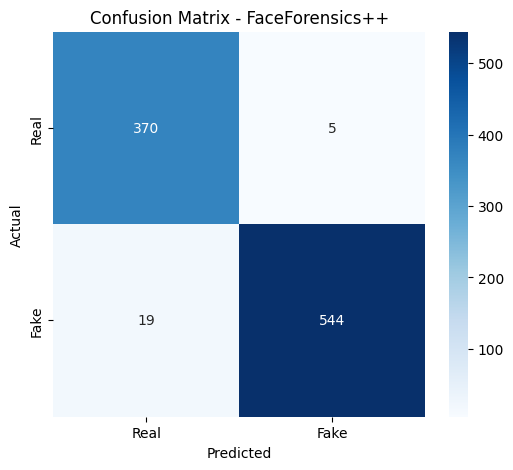

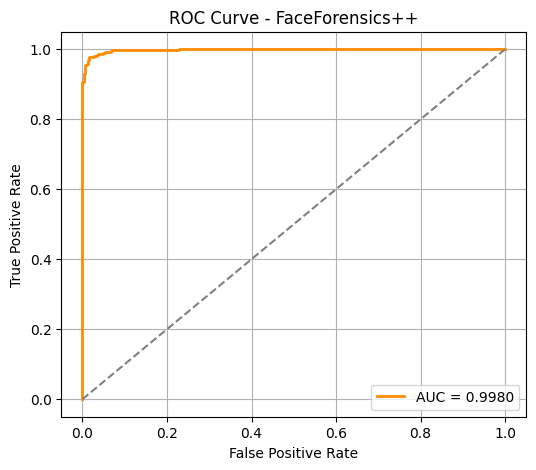

In [ ]:
plot_confusion_and_roc(model, ff_test_loader, device='cuda', title="FaceForensics++")

##### DFDC Evaluation

In [ ]:
print("DFDC Evaluation before Fine Tuning")

print("Evaluation on Train: ")
evaluate_model(model, dfdc_train_loader)
print()

print("Evaluation on Validation: ")
evaluate_model(model, dfdc_val_loader)
print()

print("Evaluation on Test: ")
evaluate_model(model, dfdc_test_loader)

DFDC Evaluation before Fine Tuning
Evaluation on Train: 


              precision    recall  f1-score   support

        Real     0.5291    0.9396    0.6770       745
        Fake     0.6512    0.1188    0.2010       707

    accuracy                         0.5399      1452
   macro avg     0.5901    0.5292    0.4390      1452
weighted avg     0.5885    0.5399    0.4452      1452

AUC-ROC: 0.6387

Evaluation on Validation: 


              precision    recall  f1-score   support

        Real     0.4022    0.8952    0.5550       124
        Fake     0.6286    0.1176    0.1982       187

    accuracy                         0.4277       311
   macro avg     0.5154    0.5064    0.3766       311
weighted avg     0.5383    0.4277    0.3405       311

AUC-ROC: 0.5842

Evaluation on Test: 


              precision    recall  f1-score   support

        Real     0.4194    0.9360    0.5792       125
        Fake     0.7576    0.1337    0.2273       187

    accuracy                         0.4551       312
   macro avg     0.5885    0.5348    0.4032       312
weighted avg     0.6221    0.4551    0.3683       312

AUC-ROC: 0.6869


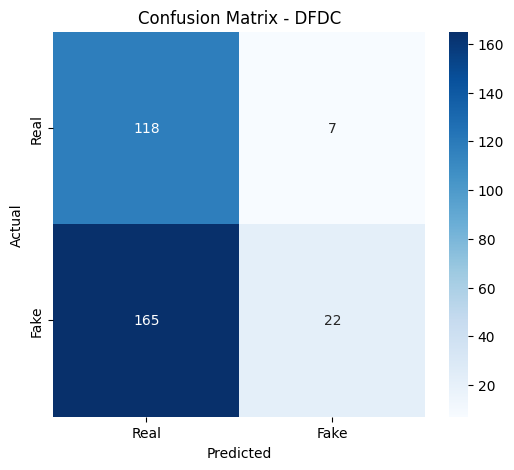

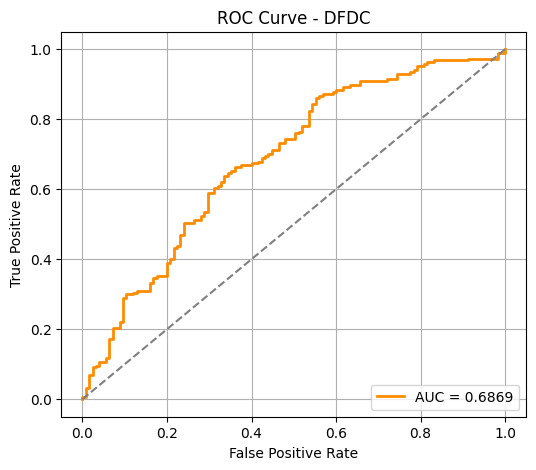

In [ ]:
plot_confusion_and_roc(model, dfdc_test_loader, device='cuda', title="DFDC")

#### Fine Tuning DFDC

In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
import random
from tqdm import tqdm
import numpy as np

# Create 20% subset of DFDC training data
def get_dfdc_subset(full_dataset, percentage=0.2, seed=42):
    random.seed(seed)
    indices = random.sample(range(len(full_dataset)), int(len(full_dataset) * percentage))
    return Subset(full_dataset, indices)

dfdc_finetune_subset = get_dfdc_subset(dfdc_train, percentage=0.2)
dfdc_finetune_loader = DataLoader(dfdc_finetune_subset, batch_size=32, shuffle=True, num_workers=2)

# Freeze all backbone layers (CNN + ViT), keep classifier trainable
for param in model.cnn_branch.parameters():
    param.requires_grad = False
for param in model.vit.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer for classifier head only
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Fine-tuning config
best_val_auc = 0
patience = 3
counter = 0
epochs = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)

print("\nStarting Fine-Tuning on 20% DFDC...\n")

# Helper to run and extract AUC from evaluate_model
def evaluate_and_return_auc(model, loader, device):
    from sklearn.metrics import roc_auc_score
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    return auc

# Fine-tuning loop
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    loop = tqdm(dfdc_finetune_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)

    for images, labels in loop:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(dfdc_finetune_loader)
    print(f"\nEpoch [{epoch}/{epochs}], Train Loss: {avg_train_loss:.4f}")

    # Evaluate on validation set
    print("\nEvaluating on DFDC Validation Set...")
    _ = evaluate_model(model, dfdc_val_loader, device=DEVICE)

    val_auc = evaluate_and_return_auc(model, dfdc_val_loader, device=DEVICE)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/deepfake_models/best_finetuned_model.pth")
        print(f"Model improved (AUC: {val_auc:.4f}). Saved.")
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} / {patience}")
        if counter >= patience:
            print("Early stopping triggered. Restoring best model...")
            model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/best_finetuned_model.pth"))
            break



Starting Fine-Tuning on 20% DFDC...




Epoch [1/10], Train Loss: 1.2052

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5000    0.1935    0.2791       124
        Fake     0.6198    0.8717    0.7244       187

    accuracy                         0.6013       311
   macro avg     0.5599    0.5326    0.5018       311
weighted avg     0.5720    0.6013    0.5469       311

AUC-ROC: 0.5984


Model improved (AUC: 0.5984). Saved.



Epoch [2/10], Train Loss: 0.8521

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.6667    0.1452    0.2384       124
        Fake     0.6268    0.9519    0.7558       187

    accuracy                         0.6302       311
   macro avg     0.6467    0.5485    0.4971       311
weighted avg     0.6427    0.6302    0.5495       311

AUC-ROC: 0.6095


Model improved (AUC: 0.6095). Saved.



Epoch [3/10], Train Loss: 0.6707

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.4848    0.6452    0.5536       124
        Fake     0.6986    0.5455    0.6126       187

    accuracy                         0.5852       311
   macro avg     0.5917    0.5953    0.5831       311
weighted avg     0.6134    0.5852    0.5891       311

AUC-ROC: 0.6258


Model improved (AUC: 0.6258). Saved.



Epoch [4/10], Train Loss: 0.7024

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5263    0.5645    0.5447       124
        Fake     0.6966    0.6631    0.6795       187

    accuracy                         0.6238       311
   macro avg     0.6115    0.6138    0.6121       311
weighted avg     0.6287    0.6238    0.6257       311

AUC-ROC: 0.6475


Model improved (AUC: 0.6475). Saved.



Epoch [5/10], Train Loss: 0.5993

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5809    0.6371    0.6077       124
        Fake     0.7429    0.6952    0.7182       187

    accuracy                         0.6720       311
   macro avg     0.6619    0.6661    0.6630       311
weighted avg     0.6783    0.6720    0.6742       311

AUC-ROC: 0.6672


Model improved (AUC: 0.6672). Saved.



Epoch [6/10], Train Loss: 0.5534

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5354    0.4274    0.4753       124
        Fake     0.6651    0.7540    0.7068       187

    accuracy                         0.6238       311
   macro avg     0.6002    0.5907    0.5911       311
weighted avg     0.6134    0.6238    0.6145       311

AUC-ROC: 0.6850


Model improved (AUC: 0.6850). Saved.



Epoch [7/10], Train Loss: 0.5559

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5476    0.3710    0.4423       124
        Fake     0.6564    0.7968    0.7198       187

    accuracy                         0.6270       311
   macro avg     0.6020    0.5839    0.5811       311
weighted avg     0.6130    0.6270    0.6092       311

AUC-ROC: 0.6961


Model improved (AUC: 0.6961). Saved.



Epoch [8/10], Train Loss: 0.5547

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.5825    0.4839    0.5286       124
        Fake     0.6923    0.7701    0.7291       187

    accuracy                         0.6559       311
   macro avg     0.6374    0.6270    0.6289       311
weighted avg     0.6485    0.6559    0.6492       311

AUC-ROC: 0.7076


Model improved (AUC: 0.7076). Saved.



Epoch [9/10], Train Loss: 0.5306

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.6018    0.5484    0.5738       124
        Fake     0.7172    0.7594    0.7377       187

    accuracy                         0.6752       311
   macro avg     0.6595    0.6539    0.6558       311
weighted avg     0.6712    0.6752    0.6723       311

AUC-ROC: 0.7153


Model improved (AUC: 0.7153). Saved.



Epoch [10/10], Train Loss: 0.5470

Evaluating on DFDC Validation Set...


              precision    recall  f1-score   support

        Real     0.6071    0.6855    0.6439       124
        Fake     0.7719    0.7059    0.7374       187

    accuracy                         0.6977       311
   macro avg     0.6895    0.6957    0.6907       311
weighted avg     0.7062    0.6977    0.7002       311

AUC-ROC: 0.7277


Model improved (AUC: 0.7277). Saved.


#### Evaluating on Fine Tune Model:

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_models/best_finetuned_model.pth"))

evaluate_model(model, dfdc_test_loader, device='cuda')

              precision    recall  f1-score   support

        Real     0.6638    0.6160    0.6390       125
        Fake     0.7551    0.7914    0.7728       187

    accuracy                         0.7212       312
   macro avg     0.7094    0.7037    0.7059       312
weighted avg     0.7185    0.7212    0.7192       312

AUC-ROC: 0.7795


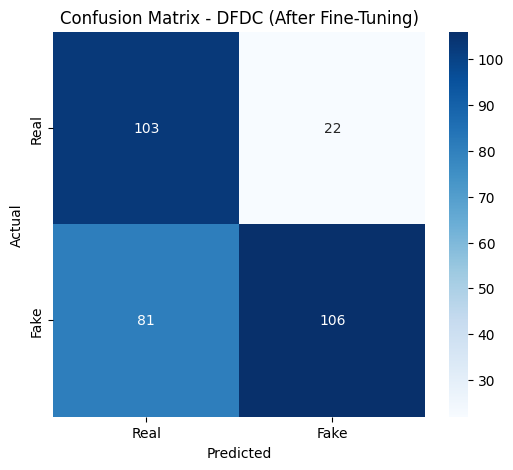

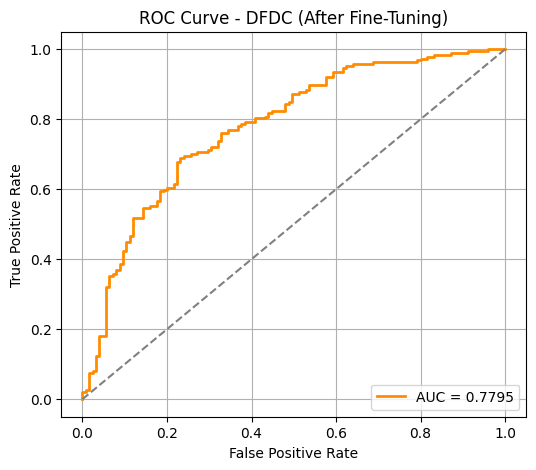

In [ ]:
plot_confusion_and_roc(model, dfdc_test_loader, device='cuda', title="DFDC (After Fine-Tuning)")